# Implementing IPP in a Simulated GP Environment
This notebook is intended for to serve as a GP playground for differnt informative path planning algorithms. 

Please note, that you may need to install the following in order to play with the [dubins library](https://github.com/AndrewWalker/Dubins-Curves) and the [Gaussian Process model](https://github.com/SheffieldML/GPy) respectively:

```pip install dubins
pip install GPy```

This library allows for the generation of a Gaussian environment with known kernel parameter and provides an point-robot interface for planning informative paths through this initially unknown environment, while collecting noisy samples of the phenonema of interest from the environment. The robot's trajectories are represented as concatonations of dubins curves, assuming that the turning radius is known. 

In [28]:
# Necessary imports
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import math
import os
import GPy as GPy
import dubins

## The GPModel Class
This custom GPModel class is the model representation used to generate a simulated Gaussian environment, and also used to represent the robot's current model of the environment. The class is a wrapper on to of the GPy library that allows for some additional features, including:
* Saving and loading trained kernel parameters
* Initializing a GP model without any prior data and adding new sample points
* Incrementally addding sample points to a previous dataset, resuing previous computation [TODO]
* Sparse, streaming GP posterior updates [TODO]

## The Squared Exponential Kernel

The GPModel currently assumes a Squared Exponential Kernel. Here is a guide to what the differnt kernel hyperparmeters mean, from [this post](http://evelinag.com/Ariadne/covarianceFunctions.html). 

\begin{equation}
\kappa(x_i, x_j) = \sigma^2 \text{exp}\Big(- \frac{(x_i - x_j)^2}{2l^2}\Big) + \sigma_{\text{noise}}^2
\end{equation} 

where $\sigma^2 > 0$ is the signal variance, $l>0$ is the lengthscale and $\sigma_{\text{noise}}^2>=0$ is the noise covariance. The noise variance is applied only when $i=j$.

Squared exponential is appropriate for modelling very smooth functions. The parameters have the following interpretation:

* **Lengthscale $l$** describes how smooth a function is. Small lengthscale value means that function values can change quickly, large values characterize functions that change only slowly. Lengthscale also determines how far we can reliably extrapolate from the training data.

* **Signal variance $\sigma^2$** is a scaling factor. It determines variation of function values from their mean. Small value of $\sigma^2$ characterize functions that stay close to their mean value, larger values allow more variation. If the signal variance is too large, the modelled function will be free to chase outliers.

* **Noise variance** $\sigma_{\text{noise}}^2$ is formally not a part of the covariance function itself. It is used by the Gaussian process model to allow for noise present in training data. This parameter specifies how much noise is expected to be present in the data.

In [2]:
class GPModel:
    '''The GPModel class, which is a wrapper on top of GPy, allowing saving and loading of trained kernel parameters.
    Inputs:
    * variance (float) the variance parameter of the squared exponential kernel
    * lengthscale (float) the lengthscale parameter of the squared exponential kernel
    * noise (float) the sensor noise parameter of the squared exponential kernel
    * dimension (float) the dimension of the environment (currently, only 2D environments are supported)
    * kernel (string) the type of kernel (currently, only 'rbf' kernels are supported) '''     
    
    def __init__(self, lengthscale, variance, noise = 0.05, dimension = 2, kernel = 'rbf'):
        '''Initialize a GP regression model with given kernel parameters. '''
        
        # The noise parameter of the sensor
        self.noise = noise
        self.lengthscale = lengthscale
        self.variance = variance
        
        # The Gaussian dataset
        self.xvals = None
        self.zvals = None
        
        # The dimension of the evironment
        if dimension == 2:
            self.dim = dimension
        else:
            raise ValueError('Environment must have dimension 2 \'rbf\'')

        if kernel == 'rbf':
            self.kern = GPy.kern.RBF(input_dim = self.dim, lengthscale = lengthscale, variance = variance) 
        else:
            raise ValueError('Kernel type must by \'rbf\'')
            
        # Intitally, before any data is created, 
        self.model = None
         
    def predict_value(self, xvals):
        ''' Public method returns the mean and variance predictions at a set of input locations.
        Inputs:
        * xvals (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2
        
        Returns: 
        * mean (float array): an nparray of floats representing predictive mean, with dimension NUM_PTS x 1         
        * var (float array): an nparray of floats representing predictive variance, with dimension NUM_PTS x 1 '''        

        assert(xvals.shape[0] >= 1)            
        assert(xvals.shape[1] == self.dim)    
        
        n_points, input_dim = xvals.shape
        
        # With no observations, predict 0 mean everywhere and prior variance
        if self.model == None:
            return np.zeros((n_points, 1)), np.ones((n_points, 1)) * self.variance
        
        # Else, return 
        mean, var = self.model.predict(xvals, full_cov = False, include_likelihood = True)
        return mean, var        
    

    def set_data(self, xvals, zvals):
        ''' Public method that updates the data in the GP model.
        Inputs:
        * xvals (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2
        * zvals (float array): an nparray of floats representing sensor observations, with dimension NUM_PTS x 1 ''' 
        
        # Save the data internally
        self.xvals = xvals
        self.zvals = zvals
        
        # If the model hasn't been created yet (can't be created until we have data), create GPy model
        if self.model == None:
            self.model = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern)
        # Else add to the exisiting model
        else:
            self.model.set_XY(X = np.array(xvals), Y = np.array(zvals))
            
        return
    
    def load_kernel(self, kernel_file = 'kernel_model.npy'):
        ''' Public method that loads kernel parameters from file.
        Inputs:
        * kernel_file (string): a filename string with the location of the kernel parameters '''    
        
        # Read pre-trained kernel parameters from file, if avaliable and no training data is provided
        if os.path.isfile(kernel_file):
            print "Loading kernel parameters from file"
            self.kern[:] = np.load(kernel_file)
        else:
            raise ValueError("Failed to load kernel. Kernel parameter file not found.")
            
        return

    def train_kernel(self, xvals = None, zvals = None, kernel_file = 'kernel_model.npy'):
        ''' Public method that optmizes kernel parameters based on input data and saves to files.
        Inputs:
        * xvals (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2
        * zvals (float array): an nparray of floats representing sensor observations, with dimension NUM_PTS x 1        
        * kernel_file (string): a filename string with the location to save the kernel parameters '''      
        
        # Read pre-trained kernel parameters from file, if avaliable and no training data is provided
        if xvals is not None and zvals is not None:
            print "Optimizing kernel parameters given data"
            # Initilaize a GP model (used only for optmizing kernel hyperparamters)
            self.m = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern)
            self.m.initialize_parameter()

            # Constrain the hyperparameters during optmization
            self.m.constrain_positive('')
            #self.m['rbf.variance'].constrain_bounded(0.01, 10)
            #self.m['rbf.lengthscale'].constrain_bounded(0.01, 10)
            self.m['Gaussian_noise.variance'].constrain_fixed(self.noise)

            # Train the kernel hyperparameters
            self.m.optimize_restarts(num_restarts = 2, messages = True)

            # Save the hyperparemters to file
            np.save(kernel_file, self.kern[:])
        else:
            raise ValueError("Failed to train kernel. No training data provided.")

    def kernel_plot(self):
        ''' Visualize the learned GP kernel '''        
        _ = self.kern.plot()
        plt.ylim([-10, 10])
        plt.xlim([-10, 10])
        plt.show()

## The Environment Class
This custom Environment class is used to represent environments of interest. Currently, the enviroment is constrained to be a rectangular region in $\mathbb{R}^2$. Upon initialization, the Environment class draws a random function from a Gaussian Process with the input covariance function. The Environment has one public method, ``sample_value``, which returns a noisy sample of the function value at a specified location. 


In [3]:
class Environment:
    '''The Environment class, which represents a retangular Gaussian world.
    
    Input:
    * ranges (tuple of floats): a tuple representing the max/min of 2D rectangular domain i.e. (-10, 10, -50, 50)
    * NUM_PTS (int): the number of points in each dimension to sample for initialization, 
                    resulting in a sample grid of size NUM_PTS x NUM_PTS
    * variance (float): the variance parameter of the squared exponential kernel
    * lengthscale (float): the lengthscale parameter of the squared exponential kernel
    * noise (float): the sensor noise parameter of the squared exponential kernel
    * visualize (boolean): a boolean flag to plot the surface of the resulting environment ''' 

    def __init__(self, ranges, NUM_PTS, variance = 0.5, lengthscale = 1.0, noise = 0.05, visualize = True, dim = 2):
        ''' Initialize a random Gaussian environment using the input kernel, assuming zero mean'''
        # Save the parmeters of GP model
        self.variance = variance
        self.lengthscale = lengthscale
        self.dim = dim
        
        # Expect ranges to be a 4-tuple consisting of x1min, x1max, x2min, and x2max
        self.x1min = float(ranges[0])
        self.x1max = float(ranges[1])
        self.x2min = float(ranges[2])
        self.x2max = float(ranges[3]) 
        
        # Intialize a GP model of the environment
        self.GP = GPModel(lengthscale = lengthscale, variance = variance)         
                            
        # Generate a set of discrete grid points, uniformly spread across the environment
        x1 = np.linspace(self.x1min, self.x1max, NUM_PTS)
        x2 = np.linspace(self.x2min, self.x2max, NUM_PTS)
        x1vals, x2vals = np.meshgrid(x1, x2, sparse = False, indexing = 'xy') # dimension: NUM_PTS x NUM_PTS
        data = np.vstack([x1vals.ravel(), x2vals.ravel()]).T # dimension: NUM_PTS*NUM_PTS x 2

        # Take an initial sample in the GP prior, conditioned on no other data
        xsamples = np.reshape(np.array(data[0, :]), (1, dim)) # dimension: 1 x 2        
        mean, var = self.GP.predict_value(xsamples)                       
        zsamples = np.random.normal(loc = mean, scale = np.sqrt(var))
        zsamples = np.reshape(zsamples, (1,1)) # dimension: 1 x 1 
                            
        # Add new data point to the GP model
        self.GP.set_data(xsamples, zsamples)                            
                                 
        # Iterate through the rest of the grid sequentially and sample a z values, condidtioned on previous samples
        for index, point in enumerate(data[1:, :]):
            # Get a new sample point
            xs = np.reshape(np.array(point), (1, dim))
    
            # Compute the predicted mean and variance
            mean, var = self.GP.predict_value(xs)
            
            # Sample a new observation, given the mean and variance
            zs = np.random.normal(loc = mean, scale = np.sqrt(var))
            
            # Add new sample point to the GP model
            zsamples = np.vstack([zsamples, np.reshape(zs, (1, 1))])
            xsamples = np.vstack([xsamples, np.reshape(xs, (1, dim))])
            self.GP.set_data(xsamples, zsamples)
      
        # Plot the surface mesh and scatter plot representation of the samples points
        if visualize == True:
            fig = plt.figure(figsize=(4, 3))
            ax = fig.add_subplot(111, projection = '3d')
            surf = ax.plot_surface(x1vals, x2vals, zsamples.reshape(x1vals.shape), cmap = cm.coolwarm, linewidth = 1)

            #ax2 = fig.add_subplot(212, projection = '3d')
            #scatter = ax2.scatter(data[:, 0], data[:, 1], zsamples, c = zsamples, cmap = cm.coolwarm)
            
            fig2 = plt.figure(figsize=(4, 3))
            ax2 = fig2.add_subplot(111)
            plot = ax2.contour(x1vals, x2vals, zsamples.reshape(x1vals.shape), cmap = 'hot')
            plt.show()           
        
        print "Environment initialized with bounds X1: (", self.x1min, ",", self.x1max, ")  X2:(", self.x2min, ",", self.x2max, ")" 
      
    def sample_value(self, xvals):
        ''' The public interface to the Environment class. Returns a noisy sample of the true value of environment 
        at a set of point. 
        Input:
        * xvals (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2 
        
        Returns:
        * mean (float array): an nparray of floats representing predictive mean, with dimension NUM_PTS x 1 '''
        assert(xvals.shape[0] >= 1)            
        assert(xvals.shape[1] == self.dim)        
        mean, var = self.GP.predict_value(xvals)
        return mean
    

## Representing Path Sets: Path Generator Classes
This custom class leverages some of the nice features of the ```dubins``` library to generate a number of options and sample sets for the vehicle to choose from.

In [6]:
class Path_Generator:
    '''The Path_Generator class which creates naive point-to-point straightline paths'''
    
    def __init__(self, frontier_size, horizon_length, turning_radius, sample_step):
        '''
        frontier_size (int) the number of points on the frontier we should consider for navigation
        horizon_length (float) distance between the vehicle and the horizon to consider
        turning_radius (float) the feasible turning radius for the vehicle
        sample_step (float) the unit length along the path from which to draw a sample
        '''
        self.fs = frontier_size
        self.hl = horizon_length
        self.tr = turning_radius
        self.ss = sample_step
        
        # Global variables
        self.goals = [] #The frontier coordinates
        self.samples = {} #The sample points which form the paths
        self.cp = (0,0,0) #The current pose of the vehicle
        
    def generate_frontier_points(self):
        '''From the frontier_size and horizon_length, generate the frontier points to goal'''
        angle = np.linspace(-2.35,2.35,self.fs) #fix the possibilities to 75% of the unit circle, ignoring points directly behind the vehicle
        self.goals = [(self.hl*np.cos(self.cp[2]+a)+self.cp[0], self.hl*np.sin(self.cp[2]+a)+self.cp[1], self.cp[2]+a) for a in angle]
        return self.goals
        
    def make_sample_paths(self):
        '''Connect the current_pose to the goal places'''
        cp = np.array(self.cp)
        coords = {}
        for i,goal in enumerate(self.goals):
            g = np.array(goal)
            distance = np.sqrt((cp[0]-g[0])**2 + (cp[1]-g[1])**2)
            samples = int(round(distance/self.ss))
            
            for i in range(0,samples):
                x = cp[0]+(i*self.ss)*np.cos(g[2])
                y = cp[1]+(i*self.ss)*np.sin(g[2])
                try: 
                    coords[i].append((x,y))
                except:
                    coords[i] = []
                    coords[i].append((x,y))
        self.samples = coords
        return coords
    
    def get_path_set(self, current_pose):
        '''Primary interface for getting list of path sample points for evaluation'''
        self.cp = current_pose
        self.generate_frontier_points()
        paths = self.make_sample_paths()
        return paths
    
    def get_frontier_points(self):
        return self.goals
    
    def get_sample_points(self):
        return self.samples

In [7]:
class Dubins_Path_Generator(Path_Generator):
    '''
    The Dubins_Path_Generator class, which inherits from the Path_Generator class. Replaces the make_sample_paths
    method with paths generated using the dubins library
    '''
        
    def make_sample_paths(self):
        '''Connect the current_pose to the goal places'''
        coords = {}
        for i,goal in enumerate(self.goals):
            g = (goal[0],goal[1],self.cp[2])
            path = dubins.shortest_path(self.cp, goal, self.tr)
            configurations, _ = path.sample_many(self.ss)
            coords[i] = configurations
        self.samples = coords
        return coords

In [8]:
class Dubins_EqualPath_Generator(Path_Generator):
    '''
    The Dubins_EqualPath_Generator class which inherits from Path_Generator. Modifies Dubin Curve paths so that all
    options have an equal number of sampling points
    '''
        
    def make_sample_paths(self):
        '''Connect the current_pose to the goal places'''
        coords = {}
        for i,goal in enumerate(self.goals):
            g = (goal[0],goal[1],self.cp[2])
            path = dubins.shortest_path(self.cp, goal, self.tr)
            configurations, _ = path.sample_many(self.ss)
            coords[i] = configurations
        
        # find the "shortest" path in sample space
        current_min = 1000
        for key,path in coords.items():
            if len(path) < current_min:
                current_min = len(path)
        
        # limit all paths to the shortest path in sample space
        for key,path in coords.items():
            if len(path) > current_min:
                path = path[0:current_min]
                coords[key]=path
        
        self.samples = coords
        return coords

## The Robot Class
This custom Robot class is used to represent a point robot with all of the requisite modeling and planning algortihms necessary to perform informative path planning in unknown Gaussian environments. The Robot class includes:
* A ``GPModel`` object, which represents the robot's current knowledge about the world, including prior information, kernel, and previously sampled points
* A ``sample_world`` function handel, which it allows it to aquire a noisy sample from the enviroment at a location/set of locations in the environment
* A [TODO] object, which represents the set of actions/paths avaliable to a robot from it's current pose
* A [TODO], which allows the robot to plan myopic trajectories
* A [TODO], which allows the robot to plan nonmyopic trajectories


In [69]:
class Robot:
    '''The Robot class, which includes the vechiles current model of the world, path set represetnation, and
        infromative path planning algorithm.
        
        * sample_world (method) a function handle that takes a set of locations as input and returns a set of observations
        * start_loc (tuple of floats) the location of the robot initially in 2-D space e.g. (0.0, 0.0)
        * kernel_file (string) a filename specifying the location of the stored kernel values
        * kernel_dataset (tuple of nparrays) a tuple (xvals, zvals), where xvals is a Npoint x 2 nparray of type float
            and zvals is a Npoint x 1 nparray of type float 
        * prior_dataset (tuple of nparrays) a tuple (xvals, zvals), where xvals is a Npoint x 2 nparray of type float
            and zvals is a Npoint x 1 nparray of type float                
        * init_variance (float) the variance parameter of the squared exponential kernel
        * init_lengthscale (float) the lengthscale parameter of the squared exponential kernel
        * noise (float) the sensor noise parameter of the squared exponential kernel '''
    
    def __init__(self, sample_world, start_loc = (0.0, 0.0, 0.0), kernel_file = None, kernel_dataset = None, prior_dataset = None, 
            init_lengthscale = 10.0, init_variance = 100.0, noise = 0.05, path_generator = 'default', frontier_size=6, horizon_length=5, 
            turning_radius=1, sample_step=0.5):
        ''' Initialize the robot class with a GP model, initial location, path sets, and prior dataset'''

        # Initialize the robot's GP model with the initial kernel parameters
        self.GP = GPModel(lengthscale = init_lengthscale, variance = init_variance)
                
        # If both a kernel training dataset and a prior dataset are provided, train the kernel using both
        # and incorporate the prior dataset into the model
        if  kernel_dataset is not None and prior_dataset is not None:
            data = np.vstack([prior_dataset[0], kernel_dataset[0]])
            observations = np.vstack([prior_dataset[1], kernel_dataset[1]])
            self.GP.train_kernel(data, observations) 
        # Train the kernel using the provided kernel dataset
        elif kernel_dataset is not None:
            self.GP.train_kernel(kernel_dataset[0], kernel_dataset[1])
        # If a kernel file is provided, load the kernel parameters
        elif kernel_file is not None:
            self.GP.load_kernel()
        # No kernel information was provided, so the kernel will be initialized with provided values
        else:
            pass
        
        # Incorporate the prior dataset into the model
        if prior_dataset is not None:
            self.GP.set_data(prior_dataset[0], prior_dataset[1]) 

        # Initial location of the robot      
        self.loc = start_loc 
        # A function handel that allows the robot to sample from the environment
        self.sample_world = sample_world
        
        # The path generation class for the robot
        path_options = {'default':Path_Generator(frontier_size, horizon_length, turning_radius, sample_step),
                        'dubins': Dubins_Path_Generator(frontier_size, horizon_length, turning_radius, sample_step),
                        'equal_dubins': Dubins_EqualPath_Generator(frontier_size, horizon_length, turning_radius, sample_step)}
        self.path_generator = path_options[path_generator]
    
    def visualize_world_model(self):
        print self.GP.xvals.shape
        x1 = self.GP.xvals[:, 0]
        x2 = self.GP.xvals[:, 1]
        
        fig = self.GP.model.plot(figsize=(4, 3))
        #display(GPy.plotting.show(fig, filename='basic_gp_regression_notebook_2d'))
        display(self.GP.model, cmap = 'viridis')
        
    def gatherSamples(self):
        ''' Some example code to gather observations at a set of locations and plot those observations
            Can be deleted'''
        ranges = (-10, 10, -10, 10)
        x1observe = np.linspace(ranges[0], ranges[1], 10)
        x2observe = np.linspace(ranges[2], ranges[3], 10)
        x1observe, x2observe= np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
        data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
        observations = self.sample_world(data)        
        fig = plt.figure()
        ax1 = fig.add_subplot(111, projection = '3d')
        surf = ax1.plot_surface(x1observe, x2observe, observations.reshape(x1observe.shape), cmap = cm.coolwarm, linewidth = 0)
        plt.show()    
    
    def assess_reward(self):
        reward = {}
        paths = self.path_generator.get_path_set(self.loc)
        for path,points in paths.items():
            cmean = 0
            cvar = 0
            data = np.array(points)
            x = data[:,0]
            y = data[:,1]
            queries = np.vstack([x,y]).T
            for q in queries:
                qu = np.reshape(np.array(q), (1, 2))
                m,v = self.GP.predict_value(qu)
                cmean += m
                cvar += v
            reward[path] = cmean + 0.3*np.fabs(cvar)
        print reward
        print max(reward, key=reward.get)

    
    

## Example initialization
To use this code, first create a global Gaussian Environment object. Then, create a Robot object, which can optionally be supplied with a prior dataset, a dataset that can be used to train kernel parameters, or a filename from which to load kernel parameters. If the ``visualize`` flag is set in the Environment model, the resulting Gaussian surface will be plotted.


<IPython.core.display.Javascript object>


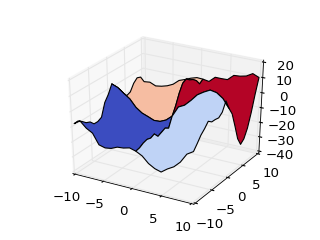

<IPython.core.display.Javascript object>


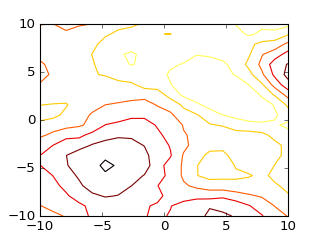

Environment initialized with bounds X1: ( -10.0 , 10.0 )  X2:( -10.0 , 10.0 )
(25, 2)


<IPython.core.display.Javascript object>


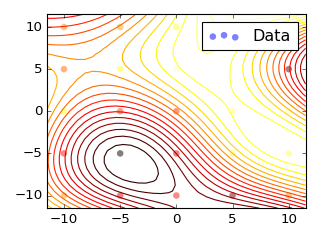

GP_regression.,value,constraints,priors
rbf.variance,100.0,+ve,
rbf.lengthscale,10.0,+ve,
Gaussian_noise.variance,1.0,+ve,


{0: array([[-157.76419442]]), 1: array([[-99.28961646]]), 2: array([[-11.94388088]]), 3: array([[ 17.46572707]]), 4: array([[ 16.52612269]]), 5: array([[-18.30137325]])}
3


In [70]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
world = Environment(ranges = (-10, 10, -10, 10), # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 3.0, 
                    visualize = True)

# Gather some prior observations to train the kernel (optional)
ranges = (-10, 10, -10, 10)
x1observe = np.linspace(ranges[0], ranges[1], 5)
x2observe = np.linspace(ranges[2], ranges[3], 5)
x1observe, x2observe= np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Robot(sample_world = world.sample_value, 
              start_loc = (0.0, 0.0, 0.0), 
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset = (data, observations), 
              init_lengthscale = 10.0, 
              init_variance = 100.0, 
              noise = 0.05,
              path_generator = 'dubins',
              frontier_size=6, 
              horizon_length=5, 
              turning_radius=1, 
              sample_step=0.5)

robot.visualize_world_model()
robot.assess_reward()

